<a href="https://colab.research.google.com/github/Hyun-Dai/AI-Art-Project/blob/main/aiartproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/ai_art_dataset/"
# Use AI Art Generator and make a raw dataset

total_dir = r"/content/drive/MyDrive/ai_art_dataset/abstract"

Mounted at /content/drive
abstract


In [ ]:
width_mean = 512
height_mean = 512

transform = transforms.Compose([transforms.CenterCrop((width_mean, height_mean)), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
# Grayscale
# transform = transforms.Compose([transforms.CenterCrop((width_mean, height_mean)), transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
total_set = datasets.ImageFolder(total_dir, transform)

In [ ]:
batch_size = 32

n = len(total_set)  # total number of examples
n_test = int(0.15 * n) # take 15% for test
n_val = int(0.15 * n) # take 15% for validation
n_train = int(0.7 * n) # take the other 70% for training
print('total_set: ', len(total_set), # verify the dataset separated correctly
      'test: ', n_test,
      'val: ', n_val,
      'train: ', n_train + 1)

test_set, val_set, train_set = torch.utils.data.dataset.random_split(total_set, [n_test, n_val, n_train + 1])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle= True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= False)

classes = ('ai_test', 'human')

total_set:  1603 test:  240 val:  240 train:  1123


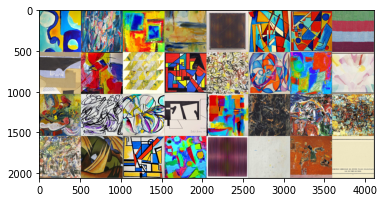

ai_test human ai_test human human ai_test ai_test human human ai_test human ai_test human ai_test ai_test human human ai_test ai_test human ai_test human human human human human ai_test ai_test human human human human


In [ ]:
# functions to show an image

def showimg(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
showimg(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Change 1 to 3 when using color images
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.do1 = nn.Dropout(0.4)
        self.do2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(5776, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.do1(x)
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = self.do2(x)
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode ='min', factor=0.1, patience=2, threshold=0.025, threshold_mode='abs')

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    training_loss = 0.0
    val_loss = 0.0
    net.train()
    count = 1
    for data, target in train_loader:
      # print("train_loader: " + str(count) + "/" + str(len(train_loader)))
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = net(data)
      loss = criterion(output, target)
      # print("loss:", loss.item())
      # scheduler.step(loss)
      loss.backward()
      optimizer.step()
      training_loss += loss.item() * data.size(0)
      count += 1


    # validate the model #
    net.eval()
    number_correct, number_data = 0, 0
    for data, target in val_loader:
      if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      output = net(data)
      loss = criterion(output, target)
      # scheduler.step(loss)
      val_loss += loss.item() * data.size(0)

    # print statistics
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    number_correct += sum(correct)
    number_data += correct.shape[0]

    train_loss = training_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    accuracy = (100 * number_correct / number_data)
    print('Epoch: {} \n-----------------\n \tTraining Loss: {:.6f} \t Validation Loss: {:.6f} \t accuracy : {:.4f}% '.format(epoch, train_loss, val_loss, accuracy))

net.to('cpu')

print('Finished Training')

Epoch: 0 
-----------------
 	Training Loss: 0.689176 	 Validation Loss: 0.696951 	 accuracy : 50.0000% 
Epoch: 1 
-----------------
 	Training Loss: 0.688743 	 Validation Loss: 0.696951 	 accuracy : 56.2500% 
Epoch: 2 
-----------------
 	Training Loss: 0.688505 	 Validation Loss: 0.696951 	 accuracy : 50.0000% 
Epoch: 3 
-----------------
 	Training Loss: 0.689603 	 Validation Loss: 0.696951 	 accuracy : 50.0000% 
Epoch: 4 
-----------------
 	Training Loss: 0.690012 	 Validation Loss: 0.696951 	 accuracy : 50.0000% 
Epoch: 5 
-----------------
 	Training Loss: 0.688534 	 Validation Loss: 0.696951 	 accuracy : 56.2500% 
Epoch: 6 
-----------------
 	Training Loss: 0.690015 	 Validation Loss: 0.696951 	 accuracy : 50.0000% 
Epoch: 7 
-----------------
 	Training Loss: 0.688681 	 Validation Loss: 0.696951 	 accuracy : 62.5000% 
Epoch: 8 
-----------------
 	Training Loss: 0.688475 	 Validation Loss: 0.696951 	 accuracy : 68.7500% 
Epoch: 9 
-----------------
 	Training Loss: 0.687961 	

In [ ]:
torch.save(net.state_dict(), "/content/drive/My Drive/TrainedModel/ai_art(abstract2)")

In [ ]:
model = Net()
model.load_state_dict(torch.load("/content/drive/My Drive/TrainedModel/ai_art(abstract2)"))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (do1): Dropout(p=0.4, inplace=False)
  (do2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=5776, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

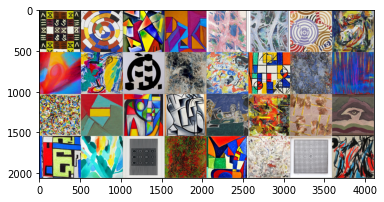

True labels:  human human ai_test ai_test human human human human ai_test ai_test human human human ai_test human ai_test human ai_test ai_test ai_test human human human human ai_test human human human ai_test human human ai_test
Predicted Labels:  human human ai_test ai_test human human human human ai_test ai_test human human human ai_test human ai_test ai_test ai_test ai_test ai_test human human human human ai_test human human human ai_test human human ai_test


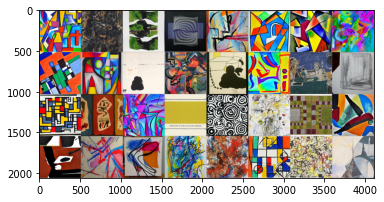

True labels:  ai_test human human human ai_test ai_test ai_test ai_test ai_test ai_test human human human ai_test human ai_test ai_test human ai_test human human human human ai_test human ai_test ai_test ai_test human ai_test human human
Predicted Labels:  ai_test human human human ai_test ai_test ai_test ai_test ai_test ai_test human human human ai_test human human ai_test ai_test ai_test human human human human ai_test human ai_test ai_test ai_test human ai_test human human


In [ ]:
def test_model(numTests):


  for i in range(numTests):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= True, num_workers = 2)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    labels = labels.cpu().detach().numpy()
    showimg(torchvision.utils.make_grid(images))
    print('True labels: ', ' '.join(f'{classes[label]}' for label in labels))
    outputs = net(images)
    _, preds = torch.max(outputs, 1)
    print('Predicted Labels: ', ' '.join(f'{classes[pred]}' for pred in preds))


test_model(2)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    j = 0
    for data in test_loader:
        j+= 1
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(j)

print(f'Accuracy of the network on the 240 test images: {100 * correct // total} %')

1
2
3
4
5
6
7
8
Accuracy of the network on the 240 test images: 92 %
